# 26 sync.Mutex与sync.RWMutex
前面的文章包括了基础概念，重要语法，高级数据类型，特色语句，测试方案等等。
这些都是go语言为我们提供的最核心的技术，已经足够让我们对Go语言有一个比较深刻的理解。

从本章开始，我们会一起讨论Go语言中自带一些比较核心的代码包。会涉及这些代码包的标准用法，使用禁忌，背后原理以及周边的知识。

注意go语言是以独特的并发编程模型傲视群雄的语言，所以这一节我们学习与并发编程关系最紧密的代码包。

## 前导内容：竞态条件、临界区与同步工具
我们首先要看的就是sync包。这里的“sync”的中文意思是**“同步”**。我们下面就从同步讲起。

相比于Go语言宣扬的“用通讯的方式共享数据”，通过共享数据的方式来传递信息和协调线程运行的做法其实更加主流，毕竟大多数的现代编程语言，都是用后一种方式作为并发编程的解决方案的（这种方案的历史非常悠久，恐怕可以追溯到上个世纪多进程编程时代伊始了）。

一旦数据被多个线程共享，那么就很可能会产生**争用和冲突**的情况。这种情况也被称为**竞态条件（race condition）**，这往往会破坏共享数据的一致性。

共享数据的`一致性`代表着某种约定，即：多个线程对共享数据的操作总是可以达到它们各自预期的效果。

如果这个一致性得不到保证，那么将会影响到一些线程中代码和流程的正确执行，甚至会造成某种不可预知的错误。这种错误一般都很难发现和定位，排查起来的成本也是非常高的，所以一定要尽量避免。**注意我们需要保证一致性，以避免较大的debug代价**

举个例子，同时有多个线程连续向同一个缓冲区写入数据块，如果没有一个机制去协调这些线程的写入操作的话，那么被写入的数据块就很可能会出现错乱。比如，在线程A还没有写完一个数据块的时候，线程B就开始写入另外一个数据块了。

显然，这两个数据块中的数据会被混在一起，并且已经很难分清了。因此，在这种情况下，我们就需要采取一些措施来协调它们对缓冲区的修改。这通常就会涉及同步。

概括来讲，**同步的用途有两个，一个是避免多个线程在同一时刻操作同一个数据块，另一个是协调多个线程，以避免它们在同一时刻执行同一个代码块。**

由于这样的数据块和代码块的背后都隐含着一种或多种资源（比如存储资源、计算资源、I/O资源、网络资源等等），所以我们可以把它们看做是共享资源，或者说共享资源的代表。我们所说的同步其实就是在控制多个线程对共享资源的访问。

一个线程在想要访问某一个共享资源的时候，需要先申请对该资源的访问权限，并且只有在申请成功之后，访问才能真正开始。

而当线程对共享资源的访问结束时，它还必须归还对该资源的访问权限，若要再次访问仍需申请。

**你可以把这里所说的访问权限想象成一块令牌，线程一旦拿到了令牌，就可以进入指定的区域，从而访问到资源，而一旦线程要离开这个区域了，就需要把令牌还回去，绝不能把令牌带走。**

如果针对某个共享资源的访问令牌只有一块，那么在同一时刻，就最多只能有一个线程进入到那个区域，并访问到该资源。

这时，我们可以说，多个并发运行的线程对这个共享资源的访问是完全串行的。只要一个代码片段需要实现对共享资源的串行化访问，就可以被视为一个临界区（critical section），也就是我刚刚说的，由于要访问到资源而必须进入的那个区域。

比如，在我前面举的那个例子中，实现了数据块写入操作的代码就共同组成了一个临界区。如果针对同一个共享资源，这样的代码片段有多个，那么它们就可以被称为相关临界区。

它们可以是一个内含了共享数据的结构体及其方法，也可以是操作同一块共享数据的多个函数。临界区总是需要受到保护的，否则就会产生竞态条件。**施加保护的重要手段之一，就是使用实现了某种同步机制的工具，也称为同步工具。**
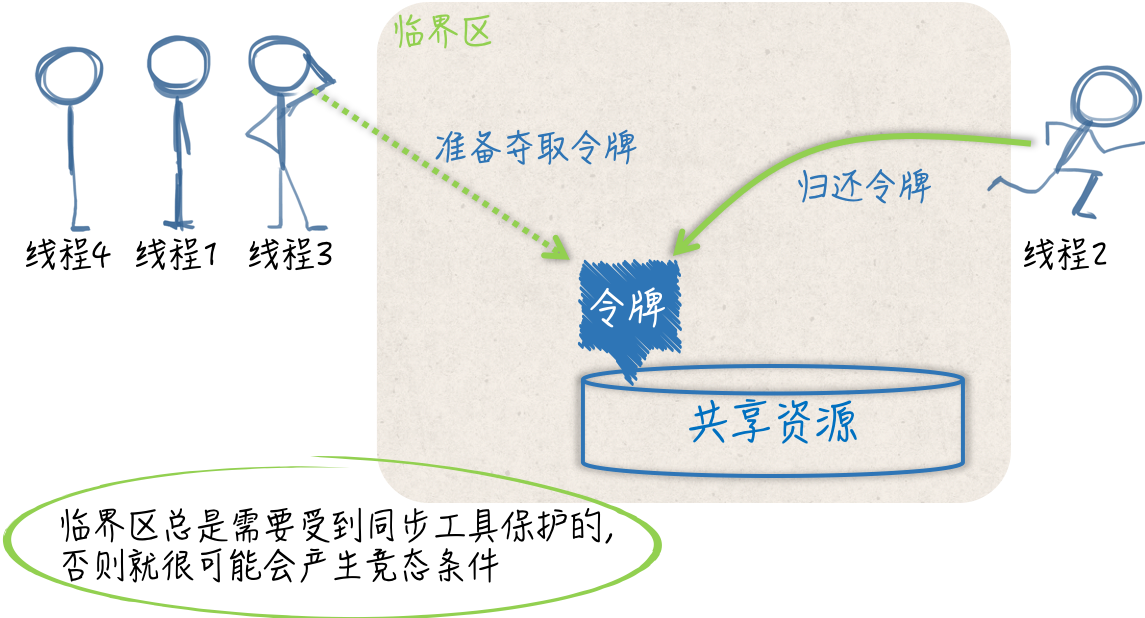

**在Go语言中，可供我们选择的同步工具并不少。其中，最重要且最常用的同步工具当属互斥量（mutual exclusion，简称mutex）。**sync包中的Mutex就是与其对应的类型，该类型的值可以被称为互斥量或者互斥锁。

一个互斥锁可以被用来保护一个临界区或者一组相关临界区。我们可以通过它来保证，在同一时刻只有一个goroutine处于该临界区之内。

为了兑现这个保证，每当有goroutine想进入临界区时，都需要先对它进行锁定，并且，每个goroutine离开临界区时，都要及时地对它进行解锁。

锁定操作可以通过调用互斥锁的Lock方法实现，而解锁操作可以调用互斥锁的Unlock方法。以下是demo58.go文件中重点代码经过简化之后的片段：

In [ ]:
mu.Lock()
_, err := writer.Write([]byte(data))
if err != nil {
 log.Printf("error: %s [%d]", err, id)
}
mu.Unlock()

你可能已经看出来了，这里的互斥锁就相当于我们前面说的那块访问令牌。那么，我们怎样才能用好这块访问令牌呢？请看下面的问题。
**我们今天的问题是：我们使用互斥锁时有哪些注意事项？**
这里有一个典型回答。

使用互斥锁的注意事项如下：

- 不要重复锁定互斥锁；
- 不要忘记解锁互斥锁，必要时使用defer语句；(注意defer是我们之前提到过的延迟语句)
- 不要对尚未锁定或者已解锁的互斥锁解锁；
- 不要在多个函数之间直接传递互斥锁。

## 问题解析
首先，你还是要把互斥锁看作是针对某一个临界区或某一组相关临界区的唯一访问令牌。

虽然没有任何强制规定来限制，你用同一个互斥锁保护多个无关的临界区，但是这样做，一定会让你的程序变得很复杂，并且也会明显地增加你的心智负担。

你要知道，对一个已经被锁定的互斥锁进行锁定，是会立即阻塞当前的`goroutine`的。这个`goroutine`所执行的流程，会一直停滞在调用该互斥锁的`Lock`方法的那行代码上。

直到该互斥锁的`Unlock`方法被调用，并且这里的锁定操作成功完成，后续的代码（也就是临界区中的代码）才会开始执行。这也正是互斥锁能够保护临界区的原因所在。

一旦，你把一个互斥锁同时用在了多个地方，就必然会有更多的goroutine争用这把锁。这不但会让你的程序变慢，还会大大增加死锁（deadlock）的可能性。

所谓的死锁，指的就是当前程序中的主`goroutine`，以及我们启用的那些`goroutine`都已经被阻塞。这些`goroutine`可以被统称为用户级的`goroutine`。这就相当于整个程序都已经停滞不前了。

Go语言运行时系统是不允许这种情况出现的，只要它发现所有的用户级goroutine都处于等待状态，就会自行抛出一个带有如下信息的panic：
fatal error: all goroutines are asleep - deadlock!

**注意，这种由Go语言运行时系统自行抛出的panic都属于致命错误，都是无法被恢复的，调用`recover`函数对它们起不到任何作用。也就是说，一旦产生死锁，程序必然崩溃。**

因此，我们一定要尽量避免这种情况的发生。而最简单、有效的方式就是让每一个互斥锁都只保护一个临界区或一组相关临界区。

在这个前提之下，我们还需要注意，对于同一个`goroutine`而言，既不要重复锁定一个互斥锁，也不要忘记对它进行解锁。

一个`goroutine`对某一个互斥锁的重复锁定，就意味着它自己锁死了自己。先不说这种做法本身就是错误的，在这种情况下，想让其他的`goroutine`来帮它解锁是非常难以保证其正确性的。

我以前就在团队代码库中见到过这样的代码。那个作者的本意是先让一个·goroutine·自己锁死自己，然后再让一个负责调度的`goroutine`定时地解锁那个互斥锁，从而让前一个`goroutine`周期性地去做一些事情，比如每分钟检查一次服务器状态，或者每天清理一次日志。

这个想法本身是没有什么问题的，但却选错了实现的工具。对于互斥锁这种需要**精细化控制*8的同步工具而言，这样的任务并不适合它。

在这种情况下，即使选用通道或者time.Ticker类型，然后自行实现功能都是可以的，程序的复杂度和我们的心智负担也会小很多，更何况还有不少已经很完备的解决方案可供选择。

话说回来，其实我们说“不要忘记解锁互斥锁”的一个很重要的原因就是：**避免重复锁定**。

因为在一个`goroutine`执行的流程中，可能会出现诸如“锁定、解锁、再锁定、再解锁”的操作，所以如果我们忘记了中间的解锁操作，那就一定会造成重复锁定。

除此之外，忘记解锁还会使其他的`goroutine`无法进入到该互斥锁保护的临界区，这轻则会导致一些程序功能的失效，重则会造成死锁和程序崩溃。

在很多时候，一个函数执行的流程并不是单一的，流程中间可能会有分叉，也可能会被中断。

如果一个流程在锁定了某个互斥锁之后分叉了，或者有被中断的可能，那么就应该使用`defer`语句来对它进行解锁，而且这样的`defer`语句应该紧跟在锁定操作之后。这是最保险的一种做法。

忘记解锁导致的问题有时候是比较隐秘的，并不会那么快就暴露出来。这也是我们需要特别关注它的原因。相比之下，解锁未锁定的互斥锁会立即引发panic。

并且，与死锁导致的panic一样，它们是无法被恢复的。因此，我们总是应该保证，对于每一个锁定操作，都要有且只有一个对应的解锁操作。

换句话说，我们应该让它们成对出现。这也算是互斥锁的一个很重要的使用原则了。在很多时候，利用defer语句进行解锁可以更容易做到这一点。

**注意我们可以让lock和unlock成对出现**
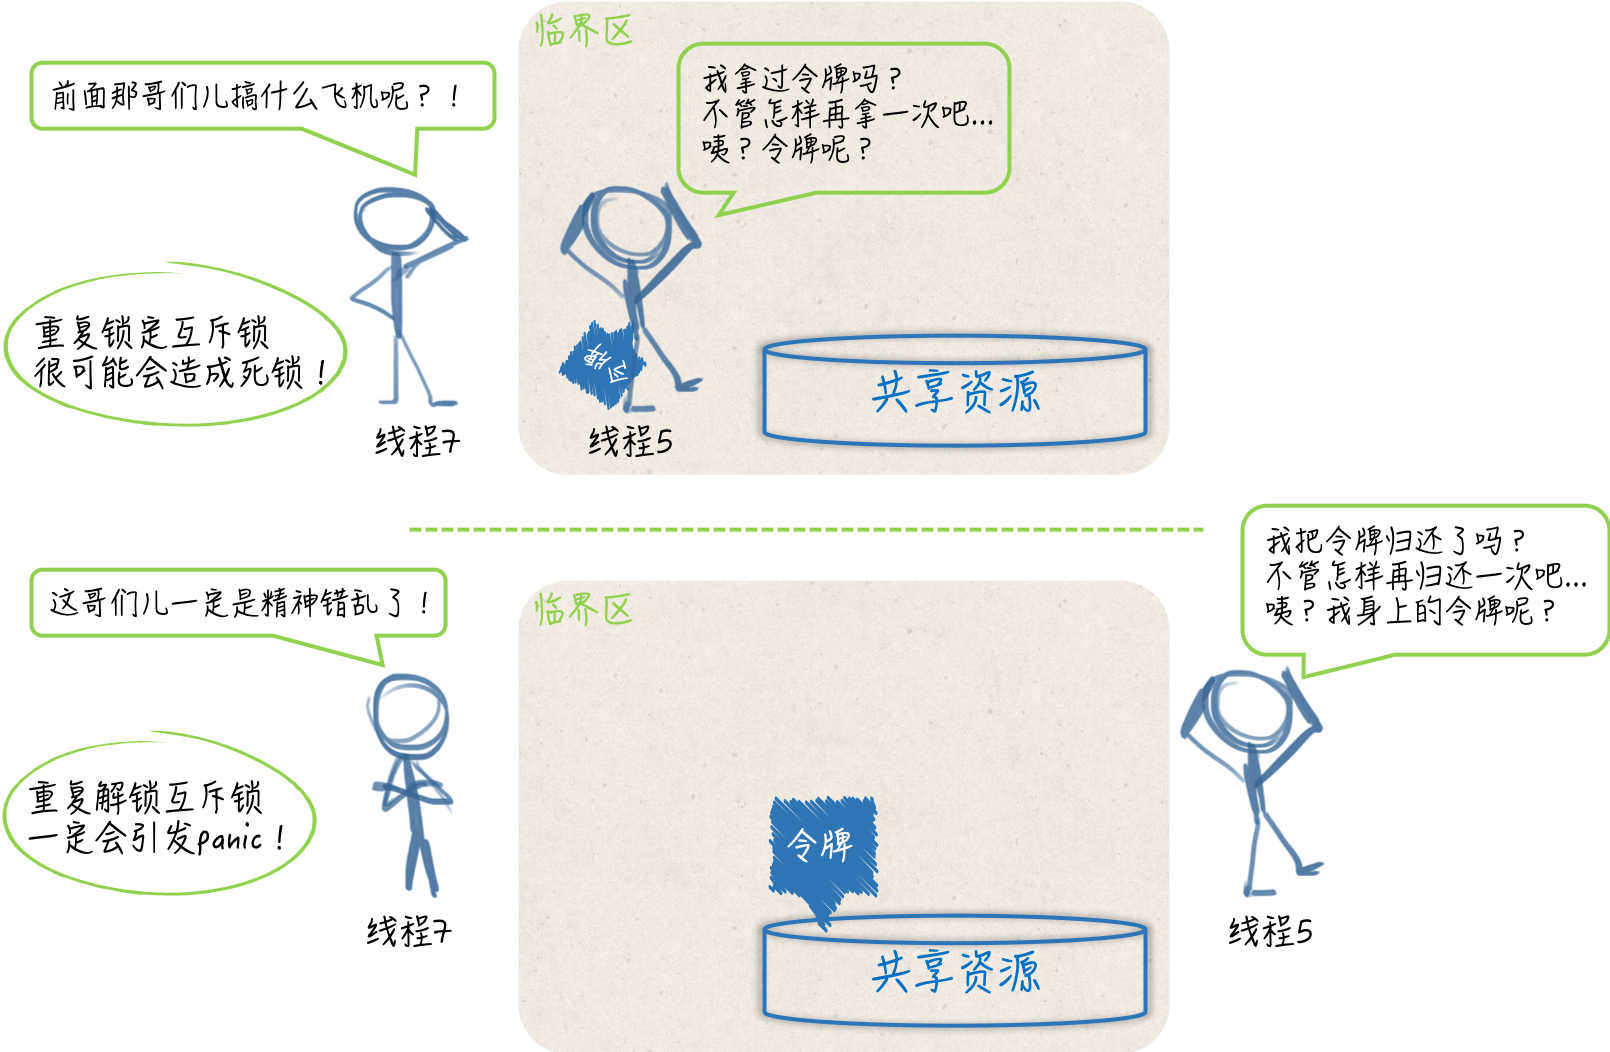


最后，可能你已经知道，Go语言中的互斥锁是开箱即用的。换句话说，一旦我们声明了一个sync.Mutex类型的变量，就可以直接使用它了。

不过要注意，**该类型是一个结构体类型，属于值类型中的一种。把它传给一个函数、将它从函数中返回、把它赋给其他变量、让它进入某个通道都会导致它的副本的产生。**

并且，原值和它的副本，以及多个副本之间都是完全独立的，它们都是不同的互斥锁。

如果你把一个互斥锁作为参数值传给了一个函数，那么在这个函数中对传入的锁的所有操作，都不会对存在于该函数之外的那个原锁产生任何的影响。

所以，你在这样做之前，一定要考虑清楚，这种结果是你想要的吗？我想，在大多数情况下应该都不是。即使你真的希望，在这个函数中使用另外一个互斥锁也不要这样做，这主要是为了**避免歧义**。

以上这些，就是我想要告诉你的关于互斥锁的锁定、解锁，以及传递方面的知识。这其中还包括了我的一些理解。希望能够对你有用。相关的例子我已经写在demo59.go文件中了，你可以去阅读一番，并运行起来看看。

## 知识扩展

问题1：读写锁与互斥锁有哪些异同？

读写锁是读/写互斥锁的简称。在Go语言中，读写锁由`sync.RWMutex`类型的值代表。与`sync.Mutex`类型一样，这个类型也是开箱即用的。

顾名思义，读写锁是把对共享资源的“读操作”和“写操作”区别对待了。它可以对这两种操作施加不同程度的保护。换句话说，相比于互斥锁，读写锁可以实现更加细腻的访问控制。

一个读写锁中实际上包含了两个锁，即：读锁和写锁。sync.RWMutex类型中的Lock方法和Unlock方法分别用于对写锁进行锁定和解锁，而它的`RLock`方法和`RUnlock`方法则分别用于对读锁进行锁定和解锁。

另外，对于同一个读写锁来说有如下规则。

在写锁已被锁定的情况下再试图锁定写锁，会阻塞当前的`goroutine`。
在写锁已被锁定的情况下试图锁定读锁，也会阻塞当前的`goroutine`。
在读锁已被锁定的情况下试图锁定写锁，同样会阻塞当前的`goroutine`。
在读锁已被锁定的情况下再试图锁定读锁，并**不会**阻塞当前的`goroutine`。
换一个角度来说，对于某个受到读写锁保护的共享资源，**多个写操作不能同时进行，写操作和读操作也不能同时进行，但多个读操作却可以同时进行**。

当然了，只有在我们正确使用读写锁的情况下，才能达到这种效果。还是那句话，我们需要让每一个锁都只保护一个临界区，或者一组相关临界区，并以此尽量减少误用的可能性。顺便说一句，我们通常把这种不能同时进行的操作称为互斥操作。

再来看另一个方面。对写锁进行解锁，会唤醒“所有因试图锁定读锁，而被阻塞的`goroutine`”，并且，这通常会使它们都成功完成对读锁的锁定。

然而，对读锁进行解锁，只会在没有其他读锁锁定的前提下，唤醒“因试图锁定写锁，而被阻塞的`goroutine`”；并且，最终只会有一个被唤醒的`goroutine`能够成功完成对写锁的锁定，其他的goroutine还要在原处继续等待。至于是哪一个goroutine，那就要看谁的等待时间最长了。

除此之外，读写锁对写操作之间的互斥，其实是通过它内含的一个互斥锁实现的。因此，也可以说，Go语言的读写锁是互斥锁的一种扩展。

最后，需要强调的是，与互斥锁类似，解锁“读写锁中未被锁定的写锁”，会立即引发panic，对于其中的读锁也是如此，并且同样是不可恢复的。

总之，读写锁与互斥锁的不同，都源于它把对共享资源的写操作和读操作区别对待了。这也使得它实现的互斥规则要更复杂一些。

不过，正因为如此，我们可以使用它对共享资源的操作，实行更加细腻的控制。另外，由于这里的读写锁是互斥锁的一种扩展，所以在有些方面它还是沿用了互斥锁的行为模式。比如，在解锁未锁定的写锁或读锁时的表现，又比如，对写操作之间互斥的实现方式。

# 总结
我们今天讨论了很多与多线程、共享资源以及同步有关的知识。其中涉及了不少重要的并发编程概念，比如，竞态条件、临界区、互斥量、死锁等。

虽然Go语言是以“用通讯的方式共享数据”为亮点的，但是它依然提供了一些易用的同步工具。其中，互斥锁是我们最常用到的一个。

互斥锁常常被用来：**保证多个goroutine并发地访问同一个共享资源时的完全串行，这是通过保护针对此共享资源的一个临界区，或一组相关临界区实现的。因此，我们可以把它看做是goroutine进入相关临界区时，必须拿到的访问令牌。**

为了用对并且用好互斥锁，我们需要了解它实现的互斥规则，更要理解一些关于它的注意事项。

比如，不要重复锁定或忘记解锁，因为这会造成goroutine不必要的阻塞，甚至导致程序的死锁。

又比如，**不要传递互斥锁，因为这会产生它的副本**，从而引起歧义并可能导致互斥操作的失效。

再次强调，我们总是应该让每一个互斥锁都只保护一个临界区，或一组相关临界区。

至于读写锁，它是互斥锁的一种扩展。我们需要知道它与互斥锁的异同，尤其是互斥规则和行为模式方面的异同。一个读写锁中同时包含了读锁和写锁，由此也可以看出它对于针对共享资源的读操作和写操作是区别对待的。我们可以基于这件事，对共享资源实施更加细致的访问控制。

最后，需要特别注意的是，**无论是互斥锁还是读写锁，我们都不要试图去解锁未锁定的锁，因为这样会引发不可恢复的panic。**

## 思考题
-你知道互斥锁和读写锁的指针类型都实现了哪一个接口吗？
互斥锁（sync.Mutex）和读写锁（sync.RWMutex）的指针类型都实现了 sync.Locker 接口。

-怎样获取读写锁中的读锁？
获取读写锁中的读锁需要调用 RLock() 方法。
对应的释放读锁的方法是 RUnlock()。